In [7]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



import shap

In [81]:
# path to the dataset
file_path = "Dry_Eye_Dataset.csv"

# Load the latest version of the file
df0 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dakshnagra/dry-eye-disease",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_5122/3521891120.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df0 = kagglehub.load_dataset(


In [82]:
df = df0.copy()

print(df.describe())

#Make everything lower case, and replace space with '_'
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Split the blood_pressure column into two new columns
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True).astype(float)

# Define the Blood Pressure Category
def categorize_bp(row):
    if 110 <= int(row['systolic']) <= 120 and 70 <= int(row['diastolic']) <= 80:
        return 'normal'
    elif int(row['systolic']) > 120 or int(row['diastolic']) > 80:
        return 'high'
    else:
        return 'low'
# New BP category column
df['bp_category'] = df.apply(categorize_bp, axis=1)
print('Types of variables in bp_category:',df['bp_category'].nunique())

#Drop Blood pressure colums including systolic and diastolic
df = df.drop(columns=['blood_pressure', 'systolic', 'diastolic'])

#Define Insomnia
def define_insomnia(row):
    criteria_met = 0
    
    # Check if each criterion is met
    if row['sleep_disorder'] == 'y':  # Only consider those with sleep disorder
        criteria_met+=1
    if row['sleep_duration'] < 6:
            criteria_met += 1
    if row['sleep_quality'] <= 3:
        criteria_met += 1
    if row['feel_sleepy_during_day'] == 'y':
        criteria_met += 1
    if row['wake_up_during_night'] == 'y':
        criteria_met += 1
    
    # Assign insomnia as 1 if 2 or more criteria are met
    if criteria_met >= 2:
        return 1
    return 0  # Insomnia = 0 if fewer than 2 criteria are met

# Apply the function to create a new column 'Insomnia'
df['insomnia'] = df.apply(define_insomnia, axis=1)
#drop used columns for insomnia
df = df.drop(columns=['sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night'])

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

omit_cols = ['medical_issue', 'stress_level', 'ongoing_medication', 'age', 'smart_device_before_bed',\
            'blue-light_filter', 'daily_steps', 'smoking', 'heart_rate', 'height',\
            'caffeine_consumption', 'weight', 'physical_activity', 'alcohol_consumption']
df = df.drop(columns=omit_cols)

                Age  Sleep duration  Sleep quality  Stress level  \
count  20000.000000    20000.000000   20000.000000  20000.000000   
mean      31.422800        6.998245       2.997250      2.993750   
std        8.103717        1.731723       1.412283      1.407235   
min       18.000000        4.000000       1.000000      1.000000   
25%       24.000000        5.500000       2.000000      2.000000   
50%       31.000000        7.000000       3.000000      3.000000   
75%       39.000000        8.500000       4.000000      4.000000   
max       45.000000       10.000000       5.000000      5.000000   

         Heart rate   Daily steps  Physical activity        Height  \
count  20000.000000  20000.000000       20000.000000  20000.000000   
mean      79.912200  10536.900000          90.069750    174.865900   
std       11.808279   5752.729186          52.317283     14.719903   
min       60.000000   1000.000000           0.000000    150.000000   
25%       70.000000   6000.000000    

In [10]:
feature_names_sort = ['medical_issue',
 'stress_level',
 'ongoing_medication',
 'age',
 'smart_device_before_bed',
 'blue-light_filter',
 'daily_steps',
 'sleep_quality',
 'smoking',
 'sleep_duration',
 'feel_sleepy_during_day',
 'heart_rate',
 'height',
 'caffeine_consumption',
 'weight',
 'physical_activity',
 'alcohol_consumption',
 'average_screen_time',
 'wake_up_during_night',
 'bp_category',
 'gender',
 'sleep_disorder',
 'discomfort_eye-strain',
 'redness_in_eye',
 'itchiness/irritation_in_eye']

In [83]:
# X=df.drop(['sleep_disorder'],axis=1)
# y=df['sleep_disorder']

X=df.drop(['dry_eye_disease'],axis=1)
y=df['dry_eye_disease']

# Encode categorical features and scale numerical ones
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Epoch 1/100, Train Loss: 0.6340, Test Loss: 0.6180
Epoch 2/100, Train Loss: 0.6223, Test Loss: 0.6129
Epoch 3/100, Train Loss: 0.6211, Test Loss: 0.6189
Epoch 4/100, Train Loss: 0.6182, Test Loss: 0.6188
Epoch 5/100, Train Loss: 0.6174, Test Loss: 0.6126
Epoch 6/100, Train Loss: 0.6164, Test Loss: 0.6212
Epoch 7/100, Train Loss: 0.6161, Test Loss: 0.6142
Epoch 8/100, Train Loss: 0.6164, Test Loss: 0.6135
Epoch 9/100, Train Loss: 0.6147, Test Loss: 0.6120
Epoch 10/100, Train Loss: 0.6150, Test Loss: 0.6122
Epoch 11/100, Train Loss: 0.6155, Test Loss: 0.6150
Epoch 12/100, Train Loss: 0.6160, Test Loss: 0.6140
Epoch 13/100, Train Loss: 0.6153, Test Loss: 0.6133
Epoch 14/100, Train Loss: 0.6147, Test Loss: 0.6137
Epoch 15/100, Train Loss: 0.6140, Test Loss: 0.6103
Epoch 16/100, Train Loss: 0.6151, Test Loss: 0.6131
Epoch 17/100, Train Loss: 0.6145, Test Loss: 0.6109
Epoch 18/100, Train Loss: 0.6135, Test Loss: 0.6127
Epoch 19/100, Train Loss: 0.6146, Test Loss: 0.6122
Epoch 20/100, Train L

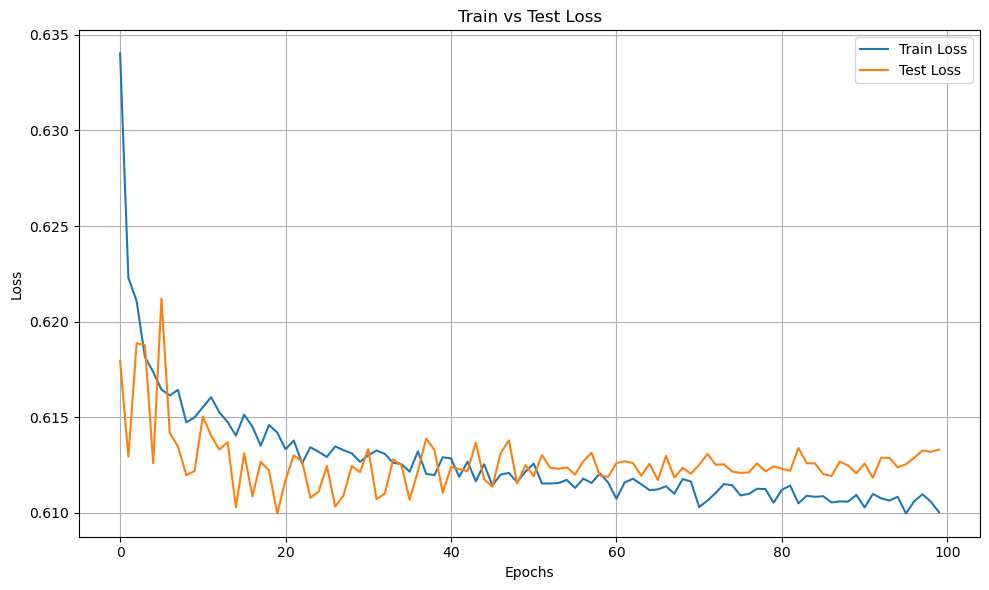

In [85]:
# Dataset
class DryEyeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DryEyeDataset(X_train, y_train)
test_dataset = DryEyeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Improved model
class DryEyeNet(nn.Module):
    def __init__(self, input_dim):
        super(DryEyeNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2)  # Binary classification
        )

    def forward(self, x):
        return self.model(x)

model = DryEyeNet(input_dim=X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

#Train Loop
# Initialize lists to store losses
train_losses = []
test_losses = []

epochs = 100
for epoch in range(epochs):
    model.train()
    running_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    
    scheduler.step()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Test loss
    model.eval()
    running_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Final evaluation accuracy
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2f}")

# Plotting losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
X=df.drop(['insomnia'],axis=1)
y=df['insomnia']

# Encode categorical features and scale numerical ones
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Epoch 1/100, Train Loss: 0.2256, Test Loss: 0.1621
Epoch 2/100, Train Loss: 0.1791, Test Loss: 0.1634
Epoch 3/100, Train Loss: 0.1770, Test Loss: 0.1623
Epoch 4/100, Train Loss: 0.1762, Test Loss: 0.1621
Epoch 5/100, Train Loss: 0.1761, Test Loss: 0.1616
Epoch 6/100, Train Loss: 0.1752, Test Loss: 0.1609
Epoch 7/100, Train Loss: 0.1760, Test Loss: 0.1616
Epoch 8/100, Train Loss: 0.1762, Test Loss: 0.1623
Epoch 9/100, Train Loss: 0.1750, Test Loss: 0.1627
Epoch 10/100, Train Loss: 0.1747, Test Loss: 0.1622
Epoch 11/100, Train Loss: 0.1752, Test Loss: 0.1611
Epoch 12/100, Train Loss: 0.1747, Test Loss: 0.1611
Epoch 13/100, Train Loss: 0.1747, Test Loss: 0.1607
Epoch 14/100, Train Loss: 0.1749, Test Loss: 0.1607
Epoch 15/100, Train Loss: 0.1747, Test Loss: 0.1612
Epoch 16/100, Train Loss: 0.1750, Test Loss: 0.1610
Epoch 17/100, Train Loss: 0.1749, Test Loss: 0.1621
Epoch 18/100, Train Loss: 0.1749, Test Loss: 0.1603
Epoch 19/100, Train Loss: 0.1746, Test Loss: 0.1604
Epoch 20/100, Train L

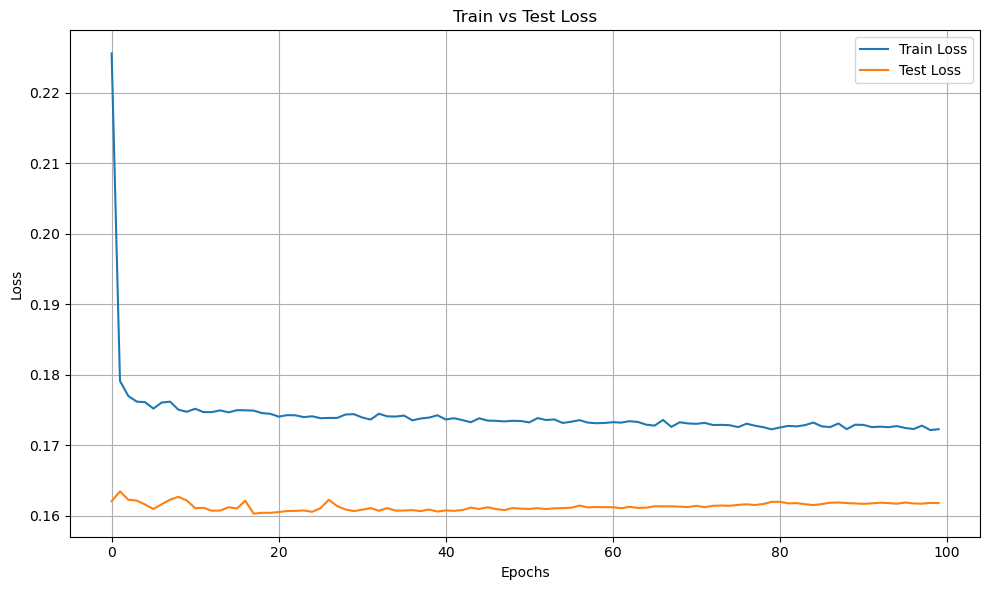

In [80]:
# Dataset
class DryEyeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DryEyeDataset(X_train, y_train)
test_dataset = DryEyeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Improved model
class DryEyeNet(nn.Module):
    def __init__(self, input_dim):
        super(DryEyeNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2)  # Binary classification
        )

    def forward(self, x):
        return self.model(x)

model = DryEyeNet(input_dim=X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

# Training loop

# Initialize lists to store losses
train_losses = []
test_losses = []

epochs = 100
for epoch in range(epochs):
    model.train()
    running_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    
    scheduler.step()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Test loss
    model.eval()
    running_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Final evaluation accuracy
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2f}")

# Plotting losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

# Let's suppose you have just 2 relevant variables
model = DiscreteBayesianNetwork([('dry_eye_disease', 'insomnia')])
model.fit(df[['dry_eye_disease', 'insomnia']], estimator=MaximumLikelihoodEstimator)

from pgmpy.inference import VariableElimination
inference = VariableElimination(model)

# Query: P(insomnia | dry eye = 1)
result = inference.query(variables=['insomnia'], evidence={'dry_eye_disease': 1})
print(result)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'dry_eye_disease': 'N', 'insomnia': 'N'}


+-------------+-----------------+
| insomnia    |   phi(insomnia) |
+=============+=================+
| insomnia(0) |          0.8078 |
+-------------+-----------------+
| insomnia(1) |          0.1922 |
+-------------+-----------------+


In [68]:
# Total number of people with dry eye disease
dry_eye_total = df[df['dry_eye_disease'] == 1].shape[0]
insomnia_total = df[df['insomnia'] == 1].shape[0]
insomnia_given_dry_eye = df[(df['insomnia']==1)&(df['dry_eye_disease'] == 1)].shape[0]

print(dry_eye_total, insomnia_total, insomnia_given_dry_eye)

# Conditional probability
if dry_eye_total > 0:
    prob = insomnia_given_dry_eye / dry_eye_total
    print(f"P(Insomnia | Dry Eye Disease) = {prob:.3f}")
else:
    print("No cases of Dry Eye Disease found in the dataset.")

13037 3867 2506
P(Insomnia | Dry Eye Disease) = 0.192


In [69]:
correlation = df['dry_eye_disease'].corr(df['insomnia'])
correlation

np.float64(-0.0039078000095854395)

In [70]:
df['both_conditions'] = ((df['insomnia'] == 1) & (df['dry_eye_disease'] == 1)).astype(int)

In [74]:
X=df.drop(['insomnia','dry_eye_disease','both_conditions'],axis=1)
y=df['both_conditions']

# Encode categorical features and scale numerical ones
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Epoch 1/100, Train Loss: 0.3968, Test Loss: 0.3937
Epoch 2/100, Train Loss: 0.3780, Test Loss: 0.3925
Epoch 3/100, Train Loss: 0.3767, Test Loss: 0.3956
Epoch 4/100, Train Loss: 0.3752, Test Loss: 0.3912
Epoch 5/100, Train Loss: 0.3748, Test Loss: 0.3906
Epoch 6/100, Train Loss: 0.3730, Test Loss: 0.3906
Epoch 7/100, Train Loss: 0.3739, Test Loss: 0.3911
Epoch 8/100, Train Loss: 0.3729, Test Loss: 0.3893
Epoch 9/100, Train Loss: 0.3728, Test Loss: 0.3910
Epoch 10/100, Train Loss: 0.3724, Test Loss: 0.3932
Epoch 11/100, Train Loss: 0.3723, Test Loss: 0.3905
Epoch 12/100, Train Loss: 0.3720, Test Loss: 0.3914
Epoch 13/100, Train Loss: 0.3723, Test Loss: 0.3944
Epoch 14/100, Train Loss: 0.3711, Test Loss: 0.3899
Epoch 15/100, Train Loss: 0.3710, Test Loss: 0.3913
Epoch 16/100, Train Loss: 0.3712, Test Loss: 0.3895
Epoch 17/100, Train Loss: 0.3720, Test Loss: 0.3902
Epoch 18/100, Train Loss: 0.3709, Test Loss: 0.3912
Epoch 19/100, Train Loss: 0.3713, Test Loss: 0.3901
Epoch 20/100, Train L

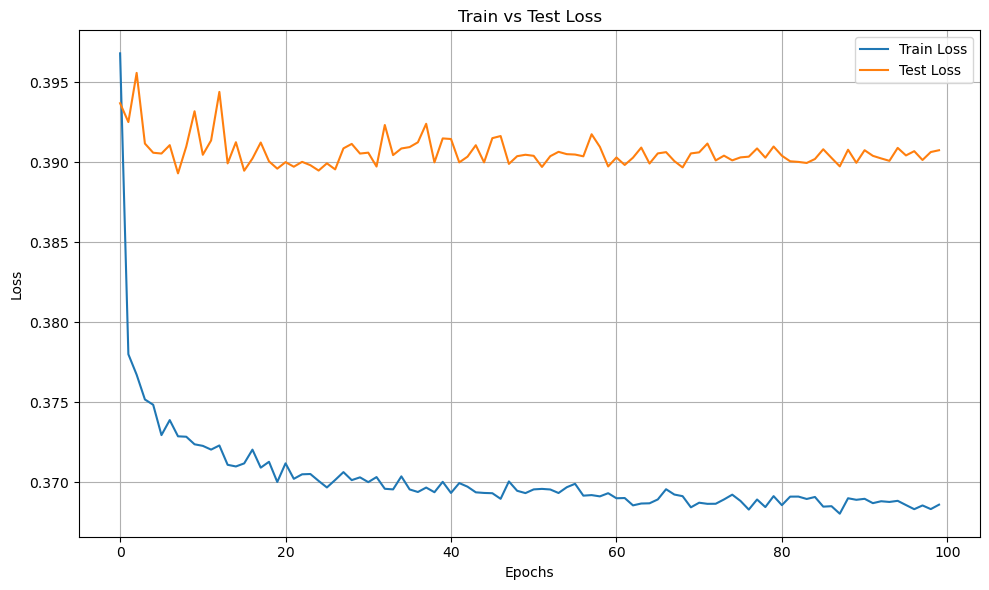

In [ ]:
# Dataset
class DryEyeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DryEyeDataset(X_train, y_train)
test_dataset = DryEyeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Improved model
class DryEyeNet(nn.Module):
    def __init__(self, input_dim):
        super(DryEyeNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2)  # Binary classification
        )

    def forward(self, x):
        return self.model(x)

model = DryEyeNet(input_dim=X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

# Training loop
# Initialize lists to store losses
train_losses = []
test_losses = []

epochs = 100
for epoch in range(epochs):
    model.train()
    running_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    
    scheduler.step()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Test loss
    model.eval()
    running_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Final evaluation accuracy
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.2f}")

# Plotting losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()